<a href="https://colab.research.google.com/github/bdip635/Histopathology-Classification/blob/main/VGG16_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import os
import math
from tqdm import tqdm

In [ ]:
!pip install pkbar
import pkbar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Setting Input Parameters

In [ ]:
#defining device
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

#Input Parameters
batch_size= 16
num_classes= 4
input_shape=(3,224,224)

cuda


In [ ]:
main = 'drive/My Drive/Course Project Image Processing - Histopathology/KMC Dataset'
work = 'drive/My Drive/Course Project Image Processing - Histopathology/VGG'

train_dir = os.path.join(main,'Training')
test_dir = os.path.join(main,'Test')
val_dir = os.path.join(main,'Validation')

check_pt_file = os.path.join(work, 'vgg16_f_cp.pth.tar')

In [ ]:
print(sorted(os.listdir(train_dir)))

print(len(os.listdir(os.path.join(train_dir,'grade0'))),len(os.listdir(os.path.join(train_dir,'grade1'))),
      len(os.listdir(os.path.join(train_dir,'grade2'))),len(os.listdir(os.path.join(train_dir,'grade3'))))
print(len(os.listdir(os.path.join(val_dir,'grade0'))),len(os.listdir(os.path.join(val_dir,'grade1'))),
      len(os.listdir(os.path.join(val_dir,'grade2'))),len(os.listdir(os.path.join(val_dir,'grade3'))))
print(len(os.listdir(os.path.join(test_dir,'grade0'))),len(os.listdir(os.path.join(test_dir,'grade1'))),
      len(os.listdir(os.path.join(test_dir,'grade2'))),len(os.listdir(os.path.join(test_dir,'grade3'))))

['grade0', 'grade1', 'grade2', 'grade3']
672 640 670 665
70 80 80 50
70 80 80 50


In [ ]:
train_data= datasets.ImageFolder(train_dir, transform= transforms.ToTensor())
val_data= datasets.ImageFolder(val_dir, transform= transforms.ToTensor())
test_data= datasets.ImageFolder(test_dir, transform= transforms.ToTensor())

In [ ]:
train_loader= DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [ ]:
class_dict=train_data.class_to_idx
print(class_dict)
class_labels = class_dict.values()
print('Labels:',class_labels)

{'grade0': 0, 'grade1': 1, 'grade2': 2, 'grade3': 3}
Labels: dict_values([0, 1, 2, 3])


#Given Data

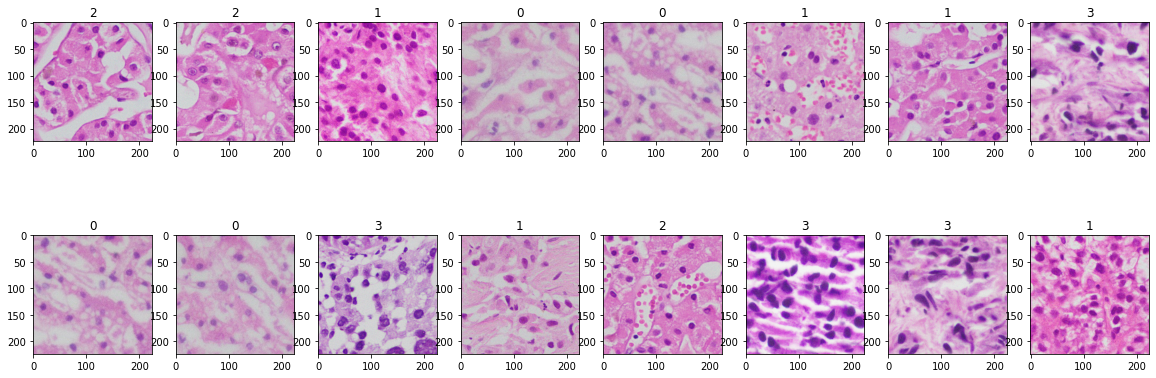

In [ ]:
iterator= iter(train_loader)
it= next(iterator)
images, labels= it

plt.figure(figsize=(20,15))
for r in range(batch_size):
    plt.subplot(4,8,r+1)
    f= plt.imshow(images[r].permute(2,1,0))
    plt.title(labels[r].item())
plt.show()

#Architecture

In [ ]:
#CONV: 3X3 filter, stride=1, 'same'; MAX-POOL: 2x2 filter, stride=2 
VGG16=[64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',512,512,512,'M']
#Then flatten and 4096x4096x1000 linear layers

class VGG_net(nn.Module):
  def __init__(self,in_channels,num_classes):
    super(VGG_net,self).__init__()
    self.in_channels=in_channels
    self.conv_layers=self.create_conv_layers(VGG16)
    self.fcs=nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,num_classes)
    )
    
  def forward(self,x):
    x=self.conv_layers(x)
    x=x.reshape(x.shape[0],-1)
    x=self.fcs(x)
    return x

  def create_conv_layers(self,architecture):
    layers=[]
    in_channels=self.in_channels

    for x in architecture:
      if type(x)==int:
        out_channels=x
        layers+=[nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                 nn.BatchNorm2d(x),
                 nn.ReLU()]
        in_channels=x
      elif x=='M':
        layers+=[nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

    return nn.Sequential(*layers)

In [ ]:
model=VGG_net(in_channels=input_shape[0],num_classes=num_classes).to(device=device)
summary(model, input_size= input_shape, batch_size=batch_size, device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 224, 224]           1,792
       BatchNorm2d-2         [16, 64, 224, 224]             128
              ReLU-3         [16, 64, 224, 224]               0
            Conv2d-4         [16, 64, 224, 224]          36,928
       BatchNorm2d-5         [16, 64, 224, 224]             128
              ReLU-6         [16, 64, 224, 224]               0
         MaxPool2d-7         [16, 64, 112, 112]               0
            Conv2d-8        [16, 128, 112, 112]          73,856
       BatchNorm2d-9        [16, 128, 112, 112]             256
             ReLU-10        [16, 128, 112, 112]               0
           Conv2d-11        [16, 128, 112, 112]         147,584
      BatchNorm2d-12        [16, 128, 112, 112]             256
             ReLU-13        [16, 128, 112, 112]               0
        MaxPool2d-14          [16, 128,

#Training

In [ ]:
# Hyperparameters
learning_rate=5e-6
num_epochs= 50

In [ ]:
Loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def check_accuracy(scores, targets):

  num_correct=0
  num_samples=0
  _, predictions= scores.max(1)
  num_correct+= (predictions== targets).sum()
  num_samples= predictions.size(0)

  return num_correct/num_samples

In [ ]:
def save_checkpoint(model, optimizer, file_name):

  checkpoint= {'state_dict': model.state_dict(),
             'optimizer_dict': optimizer.state_dict()}
  torch.save(checkpoint,file_name)

def load_checkpoint(model, optimizer, file_name):
  check_pt= torch.load(file_name)
  model.load_state_dict(check_pt['state_dict'])
  optimizer.load_state_dict(check_pt['optimizer_dict'])

  return model, optimizer

In [ ]:
train_per_epoch= len(train_loader)
val_per_epoch= len(val_loader)
min_loss= math.inf
min_loss

for epoch in range(num_epochs):
  train_losses=[]
### TRAINING
  kbar_train= pkbar.Kbar(target= train_per_epoch, epoch=epoch, num_epochs=num_epochs)

  train_loop= enumerate(train_loader)
  val_loop= enumerate(val_loader)
  for batch_idx, (data,targets) in train_loop:
    model.train()

    data= data.to(device=device)
    targets= targets.to(device=device)

    # FORWARD PROP
    scores= model(data)
    train_loss= Loss(scores, targets)
    train_losses.append(train_loss.item())

    # BACKWARD PROP
    optimizer.zero_grad()
    train_loss.backward()

    optimizer.step()

    train_acc= check_accuracy(scores,targets)
    kbar_train.update(batch_idx, values=[("loss", train_loss.item()), ("accuracy", train_acc.item())])
  kbar_train.update(train_per_epoch, values=None)
### VALIDATION
  kbar_val= pkbar.Kbar(target= val_per_epoch, epoch=epoch, num_epochs=num_epochs)
  val_losses=[]
  for batch_idx, (data, targets) in val_loop:
    model.eval()
    
    data= data.to(device=device)
    targets= targets.to(device=device)
    scores= model(data)
    val_loss= Loss(scores, targets)
    val_losses.append(val_loss.item())
    val_acc= check_accuracy(scores,targets)

    kbar_val.update(batch_idx, values=[("val_loss", val_loss.item()), ("val_accuracy", val_acc.item())])

  if np.mean(val_losses)<min_loss:
    min_loss= np.mean(val_losses)
    print('\nImproved validation loss: {:.4f}'.format(val_loss.item()))
    print('Saving the model to {}\n'.format(check_pt_file))
    save_checkpoint(model, optimizer, check_pt_file)
    
  kbar_val.update(val_per_epoch, values=None)

Epoch: 1/50
166/166 [==============================] - 687s 4s/step - loss: 0.8541 - accuracy: 0.6065
Epoch: 1/50
17/18 [===========================>..] - ETA: 3s - val_loss: 0.5639 - val_accuracy: 0.7390
Improved validation loss: 0.5407
Saving the model to drive/My Drive/Course Project Image Processing - Histopathology/VGG/vgg16_f_cp.pth.tar

18/18 [==============================] - 76s 4s/step - val_loss: 0.5639 - val_accuracy: 0.7390
Epoch: 2/50
166/166 [==============================] - 64s 385ms/step - loss: 0.4818 - accuracy: 0.7683
Epoch: 2/50
17/18 [===========================>..] - ETA: 0s - val_loss: 0.4198 - val_accuracy: 0.8015
Improved validation loss: 0.2462
Saving the model to drive/My Drive/Course Project Image Processing - Histopathology/VGG/vgg16_f_cp.pth.tar

18/18 [==============================] - 16s 903ms/step - val_loss: 0.4198 - val_accuracy: 0.8015
Epoch: 3/50
166/166 [==============================] - 64s 384ms/step - loss: 0.3690 - accuracy: 0.8216
Epoch: 3/

In [ ]:
check_pt_file1 = os.path.join(work, 'vgg16_f_w.pth.tar')
save_checkpoint(model, optimizer, check_pt_file1)

#Testing

In [ ]:
vgg16_t, _= load_checkpoint(model, optimizer, check_pt_file)

In [ ]:
def CONFUSION_MATRIX(y_true, y_pred, class_labels, order=False):
  
  num_classes= len(class_labels)
  num_examples= len(y_true)

  if order is False:
    new_labels= np.arange(num_classes)
    
    for i in range(num_examples):
      y_true[i].item= np.where(class_labels==y_true[i])[0]
      y_pred[i].item= np.where(class_labels==y_pred[i])[0]

  mat= np.zeros((num_classes,num_classes), dtype=np.int)
  
  for i in range(num_examples):
    true= np.uint8(y_true[i].item())
    pred= np.uint8(y_pred[i].item())

    mat[true,pred]+=1

  return mat


def acc_precision_recall_f1(confusion_matrix):

  num_classes= confusion_matrix.shape[0]
  precision=      np.zeros((num_classes,1), np.float64)
  recall=         np.zeros((num_classes,1), np.float64)
  true_positives= np.zeros((num_classes,1), np.float64)
  true_negatives= np.zeros((num_classes,1), np.float64)
  accuracy=       np.zeros((num_classes,1), np.float64)
  f1=             np.zeros((num_classes,1), np.float64)

  for i in range(num_classes):
    
    true_positives[i]= confusion_matrix[i,i]
    precision[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[i])
    recall[i]= confusion_matrix[i,i]/np.sum(confusion_matrix[:,i])
    f1[i]= 2*precision[i]*recall[i]/(precision[i]+recall[i])
  

  for i in range(num_classes):
    true_negatives[i]=0
    for j in range(num_classes):
      for k in range(num_classes):
        if (j!=i) and (k!=i):
          true_negatives[i]+=confusion_matrix[j,k]

  accuracy= (true_positives+true_negatives)/np.sum(confusion_matrix)
  return accuracy, precision, recall, f1


def Final_Metrics(loader, model, num_classes):
    model.eval()
    size= num_classes
    c_mat= np.zeros((size,size), dtype= np.int)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores= model(x)
            _, preds = scores.max(1)

            c_mat+= CONFUSION_MATRIX(y, preds, class_labels, order= True)
    
    accuracy, precision, recall, f1= acc_precision_recall_f1(c_mat)

    return c_mat, accuracy, precision, recall, f1

In [ ]:
confusion_matrix, accuracy, precision, recall, f1 = Final_Metrics(test_loader, vgg16_t, num_classes)

In [ ]:
print('CONFUSION MATRIX:\n',confusion_matrix,'\n')

print("PRECISION:",precision)
print("RECALL:",recall)
print("F1 SCORE:",f1)
print("ACCURACY:",accuracy)

print("PRECISION:",np.mean(precision))
print("RECALL:",np.mean(recall))
print("F1 SCORE:",np.mean(f1))
print("ACCURACY:",np.mean(accuracy))

CONFUSION MATRIX:
 [[70  0  0  0]
 [ 0 74  6  0]
 [ 0  6 74  0]
 [ 0  0  0 50]] 

PRECISION: [[1.   ]
 [0.925]
 [0.925]
 [1.   ]]
RECALL: [[1.   ]
 [0.925]
 [0.925]
 [1.   ]]
F1 SCORE: [[1.   ]
 [0.925]
 [0.925]
 [1.   ]]
ACCURACY: [[1.        ]
 [0.95714286]
 [0.95714286]
 [1.        ]]
PRECISION: 0.9625
RECALL: 0.9625
F1 SCORE: 0.9625
ACCURACY: 0.9785714285714286
